<a href="https://colab.research.google.com/github/jwlee96/ML_NHANES13_14/blob/main/MLProject_DataCleaning_RP_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import data using python directly from github
from google.colab import files
import pandas as pd
import numpy as np
import sqlite3

#create sql database for faster query
from pathlib import Path
Path('NHANES14.db').touch()

con=sqlite3.connect('NHANES14.db')
cur=con.cursor()
sqlite3.sqlite_version

#call in dataset (from online)
path1="https://raw.githubusercontent.com/jwlee96/ML_NHANES13_14/main/demographic.csv"
path2="https://raw.githubusercontent.com/jwlee96/ML_NHANES13_14/main/diet.csv"
path3="https://raw.githubusercontent.com/jwlee96/ML_NHANES13_14/main/examination.csv"
path4="https://raw.githubusercontent.com/jwlee96/ML_NHANES13_14/main/labs.csv"
path5="https://raw.githubusercontent.com/jwlee96/ML_NHANES13_14/main/medications.csv"
path6="https://raw.githubusercontent.com/jwlee96/ML_NHANES13_14/main/questionnaire.csv"

demo = pd.DataFrame(pd.read_csv(path1, index_col=0, encoding= 'unicode_escape'))
diet = pd.DataFrame(pd.read_csv(path2, index_col=0,  encoding= 'unicode_escape'))
exam = pd.DataFrame(pd.read_csv(path3, index_col=0, encoding= 'unicode_escape'))
lab = pd.DataFrame(pd.read_csv(path4, index_col=0, encoding= 'unicode_escape'))
med = pd.DataFrame(pd.read_csv(path5, index_col=0, encoding= 'unicode_escape'))
ques = pd.DataFrame(pd.read_csv(path6, index_col=0, encoding= 'unicode_escape'))

In [ ]:
#drop tables if exist
cur.execute("DROP TABLE IF EXISTS demo")
cur.execute("DROP TABLE IF EXISTS diet")
cur.execute("DROP TABLE IF EXISTS exam")
cur.execute("DROP TABLE IF EXISTS lab")
cur.execute("DROP TABLE IF EXISTS med")
cur.execute("DROP TABLE IF EXISTS ques")

In [ ]:
#reset index
demo.reset_index(inplace=True)
diet.reset_index(inplace=True)
exam.reset_index(inplace=True)
lab.reset_index(inplace=True)
med.reset_index(inplace=True)
ques.reset_index(inplace=True)

In [ ]:
#add to sql database
demo.to_sql('demo', con,  index=True, dtype={'SEQN':'INTEGER PRIMARY KEY AUTOINCREMENT'})
diet.to_sql('diet', con,  index=True, dtype={'SEQN':'INTEGER PRIMARY KEY AUTOINCREMENT'})
exam.to_sql('exam', con,  index=True, dtype={'SEQN':'INTEGER PRIMARY KEY AUTOINCREMENT'})
lab.to_sql('lab', con,  index=True, dtype={'SEQN':'INTEGER PRIMARY KEY AUTOINCREMENT'})
#med.to_sql('med', con,  index=True, dtype={'SEQN':'INTEGER PRIMARY KEY AUTOINCREMENT'}) #This is with duplicates but we don't need them.
ques.to_sql('ques', con,  index=True, dtype={'SEQN':'INTEGER PRIMARY KEY AUTOINCREMENT'})

10175

In [ ]:
#Extract Y variable; this is caires
exam1=exam.set_index('SEQN')
y_dat=exam1.filter(like='CTC') #extracting per teeth evaluation

healthy_t = ['D','S', #healthy teeth
             'U', #never popped up
             'Q','M', #missing due to non-dental disease related condition
             'K','Z', #surface condition, cannot be fully diagnoses as unhealthy
             'Y']
             #healthy teeth code

y_dat["y_val"]= [1 if x==y else 0
                 for x,y in zip(np.sum(np.isin(y_dat.values,healthy_t),1), np.sum(y_dat.notna(),1))
                 ]
y_dat.y_val.value_counts() #summarize y value.

<ipython-input-5-2c10bf4f4486>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_dat["y_val"]= [1 if x==y else 0


1    6495
0    3318
Name: y_val, dtype: int64

In [ ]:
#Use python to merge demo and diet
demo_diet = pd.merge(demo, diet, on="SEQN", how='right')
demo_diet.head() #check the data.

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0


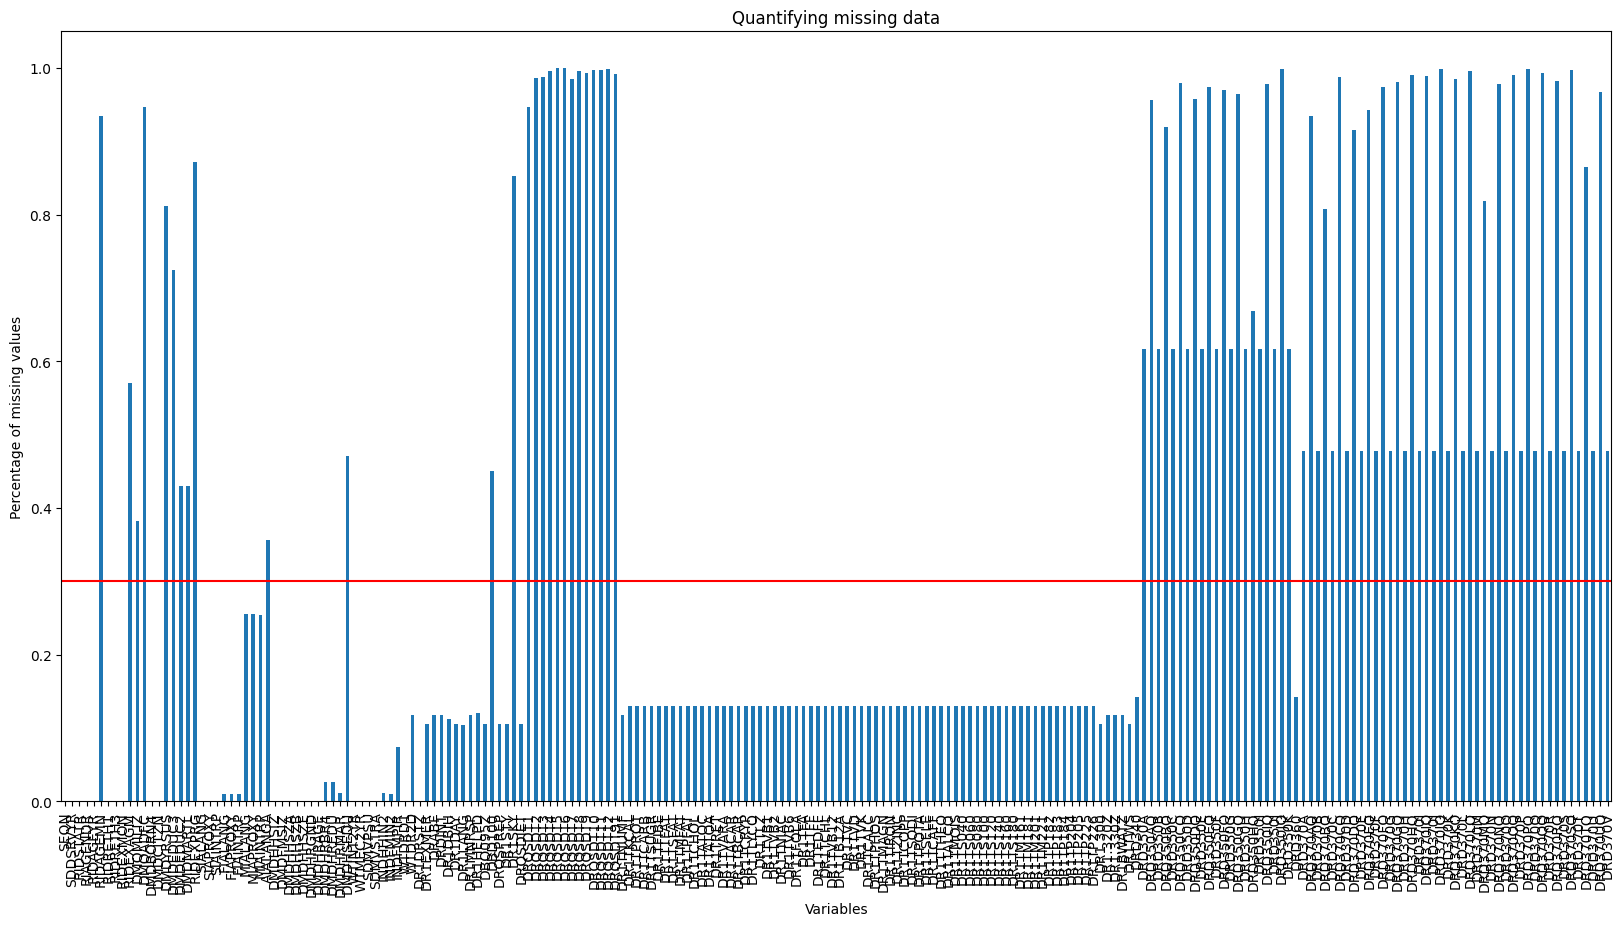

In [ ]:
#Observe missing data percentage.
import matplotlib.pyplot as plt
demo_diet.isnull().mean().plot.bar(figsize=(20,10)) #percentage of missing value
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')
plt.axhline(y=.30, color='red', linestyle='-') #any variables with more than 30% of the data missing.
plt.show()

In [ ]:
#Eliminate variables more than 30% missing.
perc=demo_diet.isnull().mean()
var = demo_diet.columns

miss30per_var= []
for i in range(demo_diet.columns.shape[0]):
  if perc[i] <.30: #threshold is 30%
    miss30per_var.append(var[i])

dd_New = demo_diet[miss30per_var]
dd_New=dd_New.set_index('SEQN')

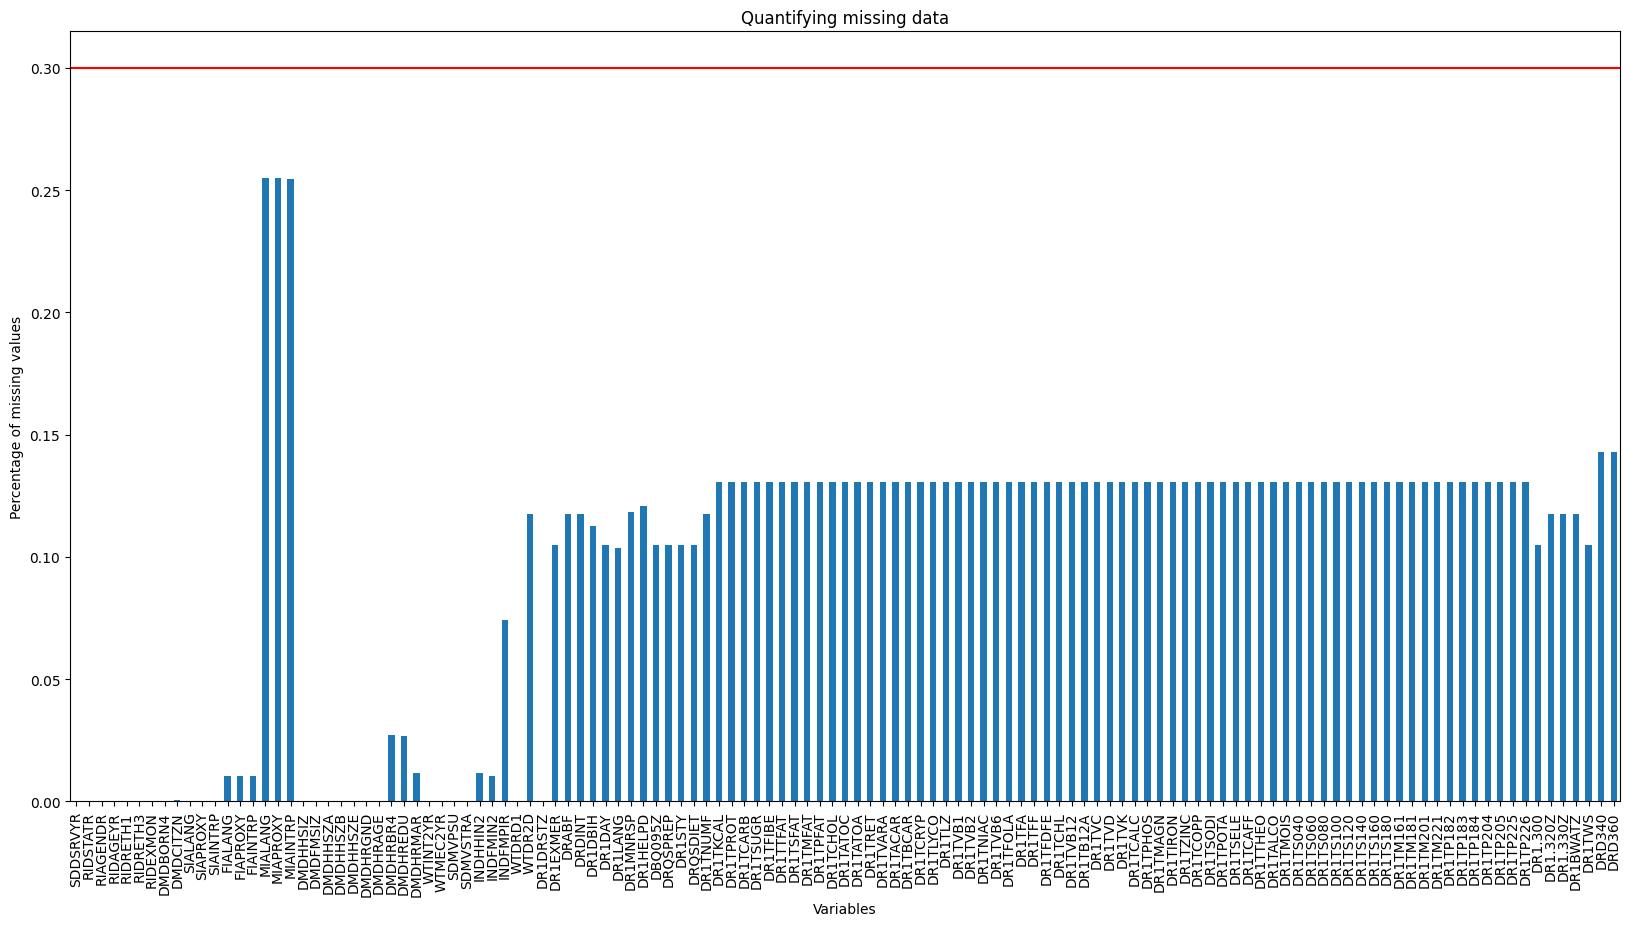

In [ ]:
#check with plot
import matplotlib.pyplot as plt
dd_New.isnull().mean().plot.bar(figsize=(20,10)) #percentage of missing value
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')
plt.axhline(y=.30, color='red', linestyle='-') #any variables with more than 30% of the data missing.
plt.show()

In [ ]:
#Check if all of those are numerical.
pd.options.display.max_columns = None
dd_New.head()

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,DMDBORN4,DMDCITZN,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGE,DMDHRBR4,DMDHREDU,DMDHRMAR,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DRQSPREP,DR1STY,DRQSDIET,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD360
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73557,8,2,1,69,4,4,1.0,1,1.0,1,2.0,2,1.0,2.0,2.0,1.0,2.0,2.0,3,3,0,0,2,1,69,1.0,3.0,4.0,13281.237386,13481.042095,1,112,4.0,4.0,0.84,16888.327864,12930.890649,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,4.0,2.0,2.0,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.0,70.0,110.0,60.0,304.0,278.0,1398.0,430.0,1.057,1.216,11.804,0.951,285.0,66.0,219.0,330.0,216.3,2.79,0.00,241.4,3.3,29.2,949.0,756.0,206.0,8.41,8.85,1.072,1323.0,2228.0,62.5,203.0,36.0,0.0,2701.79,0.219,0.099,0.103,0.153,0.346,1.221,9.694,5.408,1.173,16.796,0.121,0.001,7.932,0.769,0.000,0.094,0.001,0.000,0.010,2.0,960.0,960.0,0.0,1.0,2.0,2.0
73558,8,2,1,54,3,3,1.0,1,1.0,1,2.0,2,1.0,2.0,2.0,1.0,2.0,2.0,4,4,0,2,0,1,54,1.0,3.0,1.0,23682.057386,24471.769625,1,108,7.0,7.0,1.78,17932.143865,12684.148869,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,3.0,1.0,2.0,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.0,1477.0,1488.0,0.0,145.0,12.0,0.0,899.0,4.178,5.168,65.396,4.415,1243.0,601.0,641.0,1662.0,2149.0,21.45,0.00,2.3,15.2,23.4,3193.0,6427.0,903.0,26.88,30.36,4.130,9726.0,4930.0,715.8,240.0,0.0,119.0,6779.99,1.872,1.160,0.802,1.286,1.297,6.516,27.952,12.107,2.208,32.429,0.086,0.000,15.483,1.774,0.007,0.728,1.003,0.104,1.139,2.0,360.0,360.0,0.0,1.0,1.0,1.0
73559,8,2,1,72,3,3,2.0,1,1.0,1,2.0,2,1.0,2.0,2.0,1.0,2.0,2.0,2,2,0,0,2,1,72,1.0,4.0,1.0,57214.803319,57193.285376,1,109,10.0,10.0,4.51,59641.812930,39394.236709,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,2.0,2.0,1.0,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.0,616.0,655.0,21.0,449.0,35.0,515.0,300.0,1.648,1.747,18.342,1.906,423.0,290.0,133.0,625.0,161.2,3.78,1.42,195.1,4.0,40.4,877.0,1198.0,210.0,17.57,8.98,0.949,2943.0,1694.0,98.3,45.0,71.0,0.0,3766.70,0.358,0.128,0.371,0.455,3.008,2.067,10.691,7.497,0.531,19.910,0.164,0.005,11.705,1.092,0.000,0.042,0.001,0.006,0.002,2.0,1254.0,0.0,1254.0,1.0,1.0,2.0
73560,8,2,1,9,3,3,1.0,1,1.0,1,1.0,2,1.0,2.0,2.0,1.0,2.0,2.0,4,4,0,2,0,1,33,1.0,3.0,1.0,55201.178592,55766.512438,2,109,9.0,9.0,2.52,142203.069917,125966.366442,1,54.0,2.0,2.0,21.0,3.0,1.0,1.0,12.0,1.0,3.0,2.0,2.0,19.0,1490.0,77.75,162.92,80.58,10.6,58.27,23.511,16.986,9.617,187.0,2.16,0.0,515.0,545.0,20.0,237.0,223.0,0.0,583.0,1.407,2.186,21.903,1.807,275.0,126.0,148.0,363.0,268.9,8.76,1.55,93.0,9.9,31.5,1521.0,1495.0,183.0,14.19,13.84,0.542,2745.0,2088.0,91.2,0.0,0.0,0.0,980.45,0.265,0.201,0.213,0.385,0.907,1.979,13.051,5.384,1.009,7.771,0.203,0.003,8.466,0.948,0.002,0.089,0.007,0.006,0.004,2.0,225.0,225.0,0.0,1.0,2.0,2.0
73561,8,2,2,73,3,3,1.0,1,1.0,1,2.0,2,1.0,2.0,2.0,1.0,2.0,2.0,2,2,0,0,2,1,78,1.0,5.0,1.0,63709.667069,65541.871229,2,116,15.0,15.0,5.00,59052.357033,39004.892993,1,63.0,2.0,2.0,18.0,1.0,1.0,1.0,13.0,4.0,4.0,2.0,1.0,7.0,1421.0,55.24,178.20,87.78,12.3,55.36,4.479

In [ ]:
#Imputation using averages
from sklearn.impute import SimpleImputer
dd_New.fillna(dd_New.mean(), inplace=True) #using column averages for missing value.

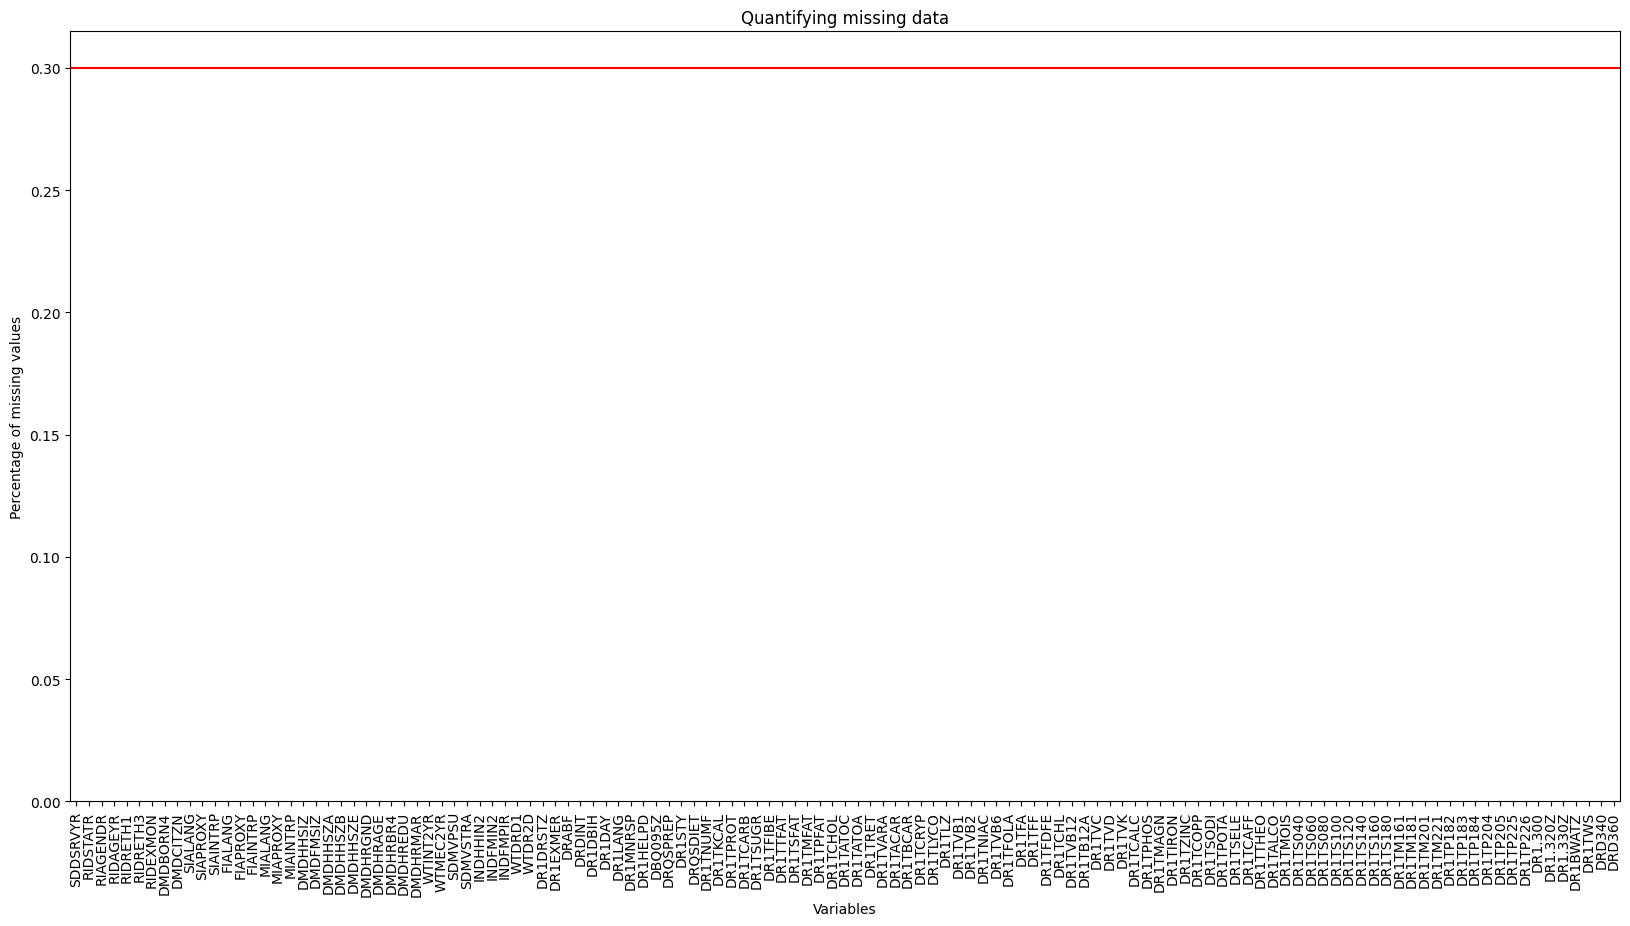

In [ ]:
#check with plot
dd_New.isnull().mean().plot.bar(figsize=(20,10)) #percentage of missing value
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')
plt.axhline(y=.30, color='red', linestyle='-') #any variables with more than 30% of the data missing.
plt.show()

In [ ]:
#normalization of the features
from sklearn import preprocessing
norm_ddNew = preprocessing.normalize(dd_New)
nm_ddNew = pd.DataFrame(norm_ddNew, index=dd_New.index, columns=dd_New.columns)
nm_ddNew.head()

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,DMDBORN4,DMDCITZN,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGE,DMDHRBR4,DMDHREDU,DMDHRMAR,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DRQSPREP,DR1STY,DRQSDIET,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD360
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73557,0.000277,0.000069,0.000035,0.002390,0.000139,0.000139,0.000035,0.000035,0.000035,0.000035,0.000069,0.000069,0.000035,0.000069,0.000069,0.000035,0.000069,0.000069,0.000104,0.000104,0.0,0.000000,0.000069,0.000035,0.002390,0.000035,0.000104,0.000139,0.460087,0.467009,0.000035,0.003880,0.000139,0.000139,0.000029,0.585044,0.447951,0.000035,0.001697,0.000069,0.000069,0.000208,0.000069,0.000035,0.000035,0.000450,0.000104,0.000139,0.000069,0.000069,0.000381,0.054526,0.001511,0.008300,0.006113,0.000374,0.001829,0.000617,0.000641,0.000306,0.007240,0.000136,0.0,0.002425,0.003811,0.002079,0.010531,0.009630,0.048429,0.014896,0.000037,0.000042,0.000409,0.000033,0.009873,0.002286,0.007587,0.011432,0.007493,0.000097,0.000000,0.008363,0.000114,0.001012,0.032875,0.026189,0.007136,0.000291,0.000307,0.000037,0.045831,0.077182,0.002165,0.007032,0.001247,0.000000,0.093595,7.586577e-06,3.429549e-06,3.568116e-06,5.300212e-06,1.198610e-05,4.229777e-05,0.000336,0.000187,4.063495e-05,0.000582,4.191671e-06,3.464191e-08,0.000275,2.663963e-05,0.000000e+00,3.256339e-06,3.464191e-08,0.000000e+00,3.464191e-07,0.000069,0.033256,0.033256,0.000000,0.000035,0.000069,0.000069
73558,0.000183,0.000046,0.000023,0.001236,0.000069,0.000069,0.000023,0.000023,0.000023,0.000023,0.000046,0.000046,0.000023,0.000046,0.000046,0.000023,0.000046,0.000046,0.000092,0.000092,0.0,0.000046,0.000000,0.000023,0.001236,0.000023,0.000069,0.000023,0.542198,0.560278,0.000023,0.002473,0.000160,0.000160,0.000041,0.410554,0.290402,0.000023,0.001351,0.000046,0.000046,0.000092,0.000023,0.000023,0.000023,0.000298,0.000023,0.000069,0.000023,0.000046,0.000183,0.115894,0.007741,0.009702,0.001030,0.000382,0.002846,0.001223,0.000812,0.000469,0.059160,0.000479,0.0,0.033816,0.034068,0.000000,0.003320,0.000275,0.000000,0.020583,0.000096,0.000118,0.001497,0.000101,0.028458,0.013760,0.014676,0.038051,0.049201,0.000491,0.000000,0.000053,0.000348,0.000536,0.073103,0.147145,0.020674,0.000615,0.000695,0.000095,0.222676,0.112872,0.016388,0.005495,0.000000,0.002724,0.155227,4.285923e-05,2.655807e-05,1.836170e-05,2.944283e-05,2.969467e-05,1.491831e-04,0.000640,0.000277,5.055191e-05,0.000742,1.968960e-06,0.000000e+00,0.000354,4.061553e-05,1.602642e-07,1.666748e-05,2.296357e-05,2.381068e-06,2.607728e-05,0.000046,0.008242,0.008242,0.000000,0.000023,0.000023,0.000023
73559,0.000074,0.000018,0.000009,0.000666,0.000028,0.000028,0.000018,0.000009,0.000009,0.000009,0.000018,0.000018,0.000009,0.000018,0.000018,0.000009,0.000018,0.000018,0.000018,0.000018,0.0,0.000000,0.000018,0.000009,0.000666,0.000009,0.000037,0.000009,0.529176,0.528977,0.000009,0.001008,0.000092,0.000092,0.000042,0.551624,0.364355,0.000009,0.000453,0.000018,0.000018,0.000166,0.000055,0.000009,0.000009,0.000120,0.000009,0.000018,0.000018,0.000009,0.000250,0.016121,0.000598,0.00

In [ ]:
#train/test data split 30:70
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(nm_ddNew, y_dat.y_val, test_size=0.30, random_state=42)

In [ ]:
print("number of features:", len(X_train.columns), "training dataset size:", X_train.shape[0], "test dataset size:", X_test.shape[0])

number of features: 123 training dataset size: 6869 test dataset size: 2944


#Random Forest Model with Python



In [ ]:
#libraries for the Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.stats import randint

#Initial Model Fit
rf = RandomForestClassifier() #set the model
rf.fit(X_train, y_train) #train data insert
y_pred = rf.predict(X_test) #test
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(rf.fit)

              precision    recall  f1-score   support

           0       0.76      0.71      0.74       994
           1       0.86      0.89      0.87      1950

    accuracy                           0.83      2944
   macro avg       0.81      0.80      0.80      2944
weighted avg       0.83      0.83      0.83      2944

[[ 708  286]
 [ 220 1730]]
<bound method BaseForest.fit of RandomForestClassifier()>


In [ ]:
#hyperparameter tuning using gridsearch cv
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', None], #mtry
    'max_depth': [5,10,15],
    'max_leaf_nodes': [5, 10, 15]
}

In [ ]:
#grid_search = GridSearchCV(RandomForestClassifier(),param_grid=param_grid)
#grid_search.fit(X_train, y_train)

In [ ]:
#print(grid_search.best_estimator_)

In [ ]:
rf_tune=RandomForestClassifier(max_depth=10,
                               max_leaf_nodes=15)

In [ ]:
rf_tune.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_leaf_nodes=15)

In [ ]:
rf_tunepred = rf_tune.predict(X_test)
print(classification_report(y_test, rf_tunepred))
print(confusion_matrix(y_test, rf_tunepred ))
print(rf_tune.fit)

              precision    recall  f1-score   support

           0       0.78      0.59      0.67       994
           1       0.81      0.92      0.86      1950

    accuracy                           0.81      2944
   macro avg       0.80      0.75      0.77      2944
weighted avg       0.80      0.81      0.80      2944

[[ 586  408]
 [ 161 1789]]
<bound method BaseForest.fit of RandomForestClassifier(max_depth=10, max_leaf_nodes=15)>


#MLP (ANN) model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

#Suggested model by author. This looks wrong

learning_rate = 0.5 #suggested from the paper

#define keras model
model1= Sequential()
model1.add(Dense(123, input_shape=(123,), activation= 'relu', name="dense_ini")) #123 features in total.
model1.add(BatchNormalization())

model1.add(Dense(100, input_shape=(123,), activation= 'relu', name="dense1")) #100 feature
model1.add(BatchNormalization())

model1.add(Dropout(learning_rate, name="dropout1")) #dropout allows randomly selecting nodes to be removed

model1.add(Dense(1000,  input_shape=(100,), activation= 'relu', name="dense2")) #expand?
model1.add(BatchNormalization())


model1.add(Dropout(learning_rate, name="dropout2"))

model1.add(Dense(100, input_shape=(1000,), activation= 'relu', name="dense3")) #100 features
model1.add(BatchNormalization())


model1.add(Dropout(learning_rate, name="dropout3"))

model1.add(Dense(100, input_shape=(100,), activation= 'relu', name="dense4"))

model1.add(Dropout(learning_rate, name="dropout4"))

model1.add(Dense(1, input_shape=(100,), activation='softmax'))


#model complile
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# Train model
model1.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_data=(X_test, y_test))

score = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
108/108 [==============================] - 9s 13ms/step - loss: 0.7904 - accuracy: 0.6617 - val_loss: 0.7008 - val_accuracy: 0.6624
Epoch 2/100
108/108 [==============================] - 1s 12ms/step - loss: 0.6906 - accuracy: 0.6617 - val_loss: 0.6604 - val_accuracy: 0.6624
Epoch 3/100
108/108 [==============================] - 1s 11ms/step - loss: 0.6511 - accuracy: 0.6617 - val_loss: 0.6736 - val_accuracy: 0.6624
Epoch 4/100
108/108 [==============================] - 1s 11ms/step - loss: 0.6148 - accuracy: 0.6617 - val_loss: 0.6242 - val_accuracy: 0.6624
Epoch 5/100
108/108 [==============================] - 1s 12ms/step - loss: 0.5939 - accuracy: 0.6617 - val_loss: 0.6133 - val_accuracy: 0.6624
Epoch 6/100
108/108 [==============================] - 2s 17ms/step - loss: 0.5770 - accuracy: 0.6617 - val_loss: 0.5625 - val_accuracy: 0.6624
Epoch 7/100
108/108 [==============================] - 2s 19ms/step - loss: 0.5706 - accuracy: 0.6617 - val_loss: 0.5522 - val_accuracy:

In [ ]:
#Softmax appropriate results?
y_prob=model1.predict(X_test, verbose=1)
y_predNN = np.argmax(y_prob, axis=-1)
print(y_predNN)

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
print(classification_report(y_test, y_predNN))
print(confusion_matrix(y_test, y_predNN))

92/92 [==============================] - 0s 2ms/step
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.34      1.00      0.50       994
           1       0.00      0.00      0.00      1950

    accuracy                           0.34      2944
   macro avg       0.17      0.50      0.25      2944
weighted avg       0.11      0.34      0.17      2944

[[ 994    0]
 [1950    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#second try
y_probNN = model1.predict(X_test, verbose=1) #odd result
y_predNN  = y_probNN>0.5

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
print(classification_report(y_test, y_predNN))
print(confusion_matrix(y_test, y_predNN))

#model is basically useless, it only pulls out 0.

92/92 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       994
           1       0.66      1.00      0.80      1950

    accuracy                           0.66      2944
   macro avg       0.33      0.50      0.40      2944
weighted avg       0.44      0.66      0.53      2944

[[   0  994]
 [   0 1950]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
sum(y_probNN)/len(y_probNN) #get averages of the probability result

array([0.99999994], dtype=float32)

(array([   0.,    0.,    0.,    0.,    0., 2944.,    0.,    0.,    0.,
           0.]),
 array([0.49999994, 0.59999996, 0.69999993, 0.79999995, 0.89999992,
        0.99999994, 1.0999999 , 1.19999993, 1.29999995, 1.39999998,
        1.5       ]),
 <BarContainer object of 10 artists>)

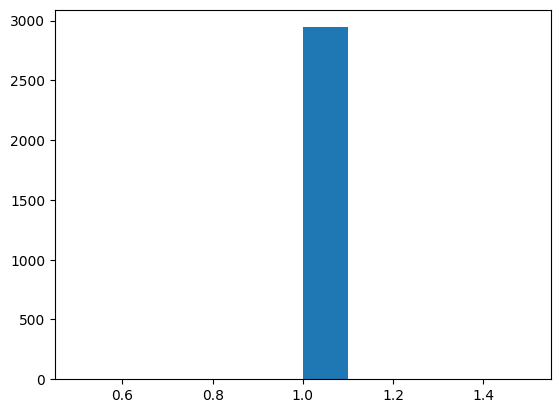

In [ ]:
plt.hist(y_probNN) #probability is consistently 1. This is odd.

Random Model: ROC AUC=0.500
ANN: ROC AUC=0.500


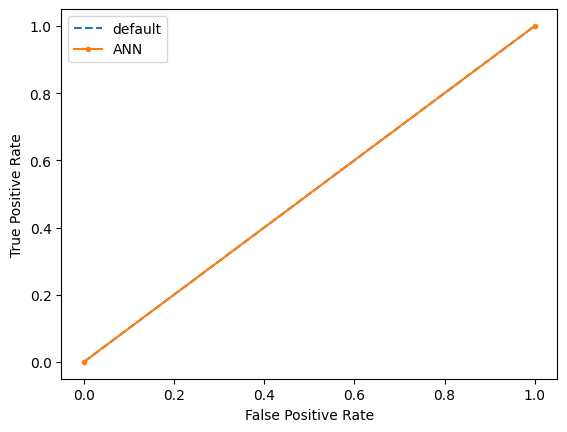

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ann_probs = y_probNN
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
ann_auc = roc_auc_score(y_test, ann_probs)
# summarize scores
print('Random Model: ROC AUC=%.3f' % (ns_auc))
print('ANN: ROC AUC=%.3f' % (ann_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ann_fpr, ann_tpr, _ = roc_curve(y_test, ann_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='default')
plt.plot(ann_fpr, ann_tpr, marker='.', label='ANN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# Summary of neural network
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_ini (Dense)           (None, 123)               15252     
                                                                 
 batch_normalization (Batch  (None, 123)               492       
 Normalization)                                                  
                                                                 
 dense1 (Dense)              (None, 100)               12400     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dropout1 (Dropout)          (None, 100)               0         
                                                                 
 dense2 (Dense)              (None, 1000)              1

In [ ]:
  #revised model 1; Sigmoid function
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

  model2= Sequential()

  learning_rate=0.5
  model2.add(Dense(123, input_shape=(123,), activation= 'relu', name="dense_ini")) #123 features in total.
  model2.add(BatchNormalization())

  model2.add(Dense(100, input_shape=(123,), activation= 'relu', name="dense1")) #100 feature
  model2.add(BatchNormalization())

  model2.add(Dropout(learning_rate, name="dropout1")) #dropout allows randomly selecting nodes to be removed

  model2.add(Dense(1000,  input_shape=(100,), activation= 'relu', name="dense2")) #expand?
  model2.add(BatchNormalization())


  model2.add(Dropout(learning_rate, name="dropout2"))

  model2.add(Dense(100, input_shape=(1000,), activation= 'relu', name="dense3")) #100 features
  model2.add(BatchNormalization())


  model2.add(Dropout(learning_rate, name="dropout3"))

  model2.add(Dense(100, input_shape=(100,), activation= 'relu', name="dense4"))
  model2.add(BatchNormalization())

  model2.add(Dropout(learning_rate, name="dropout4"))

  model2.add(Dense(1, input_shape=(100,), activation='sigmoid'))


  #model complile
  model2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


  # Train model
  model2.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_data=(X_test, y_test))

  score = model2.evaluate(X_test, y_test, verbose=1)
  print('loss:', score[0])
  print('Test accuracy:', score[1])

Epoch 1/100
108/108 [==============================] - 4s 16ms/step - loss: 0.8266 - accuracy: 0.5800 - val_loss: 0.6817 - val_accuracy: 0.6111
Epoch 2/100
108/108 [==============================] - 2s 20ms/step - loss: 0.6913 - accuracy: 0.6301 - val_loss: 0.6649 - val_accuracy: 0.5921
Epoch 3/100
108/108 [==============================] - 3s 29ms/step - loss: 0.6604 - accuracy: 0.6532 - val_loss: 0.6479 - val_accuracy: 0.6131
Epoch 4/100
108/108 [==============================] - 3s 26ms/step - loss: 0.6292 - accuracy: 0.6707 - val_loss: 0.6203 - val_accuracy: 0.6223
Epoch 5/100
108/108 [==============================] - 3s 28ms/step - loss: 0.5964 - accuracy: 0.6966 - val_loss: 0.5761 - val_accuracy: 0.7069
Epoch 6/100
108/108 [==============================] - 1s 13ms/step - loss: 0.5816 - accuracy: 0.7032 - val_loss: 0.5488 - val_accuracy: 0.7228
Epoch 7/100
108/108 [==============================] - 2s 19ms/step - loss: 0.5705 - accuracy: 0.7088 - val_loss: 0.5591 - val_accuracy:

In [ ]:
#Optimal Cutoff search function.
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

In [ ]:
# Add prediction probability to dataframe
y_probNN = model2.predict(X_test, verbose=0)
# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_test, y_probNN)
print(threshold) #optimal threshold is 0.5

[0.6435198187828064]


In [ ]:
#check the performance
y_predNN  = y_probNN>threshold

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
print(classification_report(y_test, y_predNN))
print(confusion_matrix(y_test, y_predNN))

              precision    recall  f1-score   support

           0       0.69      0.81      0.74       994
           1       0.89      0.81      0.85      1950

    accuracy                           0.81      2944
   macro avg       0.79      0.81      0.80      2944
weighted avg       0.82      0.81      0.81      2944

[[ 807  187]
 [ 368 1582]]


Random Model: ROC AUC=0.500
ANN: ROC AUC=0.890


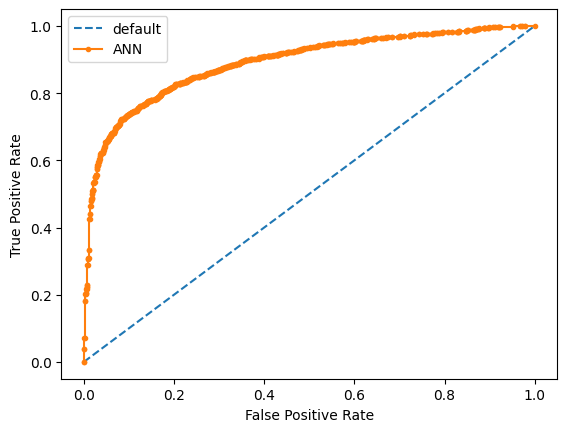

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ann_probs = y_probNN
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
ann_auc = roc_auc_score(y_test, ann_probs)
# summarize scores
print('Random Model: ROC AUC=%.3f' % (ns_auc))
print('ANN: ROC AUC=%.3f' % (ann_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ann_fpr, ann_tpr, _ = roc_curve(y_test, ann_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='default')
plt.plot(ann_fpr, ann_tpr, marker='.', label='ANN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#hyperparameter tuning; Learning Rate

In [ ]:
rate_res = pd.DataFrame(columns=['rates','Test_loss','Test_acc'])
rate_res.rates= pd.to_numeric([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
for i in range(9):
  learning_rate=rate_res.rates[i]

  #define keras model
  model= Sequential()
  model.add(Dense(123, input_shape=(123,), activation= 'relu', name="dense_ini")) #123 features in total.
  model.add(BatchNormalization())

  model.add(Dense(100, input_shape=(123,), activation= 'relu', name="dense1")) #100 feature
  model.add(BatchNormalization())

  model.add(Dropout(learning_rate, name="dropout1")) #dropout allows randomly selecting nodes to be removed

  model.add(Dense(1000,  input_shape=(100,), activation= 'relu', name="dense2")) #expand?
  model.add(BatchNormalization())


  model.add(Dropout(learning_rate, name="dropout2"))

  model.add(Dense(100, input_shape=(1000,), activation= 'relu', name="dense3")) #100 features
  model.add(BatchNormalization())


  model.add(Dropout(learning_rate, name="dropout3"))

  model.add(Dense(100, input_shape=(100,), activation= 'relu', name="dense4"))

  model.add(Dropout(learning_rate, name="dropout4"))

  model.add(Dense(1, input_shape=(100,), activation='sigmoid'))


  #model complile
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])


  # Train model
  model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=0, validation_data=(X_test, y_test))

  score = model.evaluate(X_test, y_test, verbose=0)
  print('loss:', score[0])
  print('Test accuracy:', score[1])

  rate_res.Test_loss[i]=score[0]
  rate_res.Test_acc[i]=score[1]

loss: 0.6397614479064941
Test accuracy: 0.7286005616188049


<ipython-input-58-5faafd4954df>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_loss[i]=score[0]
<ipython-input-58-5faafd4954df>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_acc[i]=score[1]


loss: 0.505472719669342
Test accuracy: 0.79347825050354


<ipython-input-58-5faafd4954df>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_loss[i]=score[0]
<ipython-input-58-5faafd4954df>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_acc[i]=score[1]


loss: 0.4064945876598358
Test accuracy: 0.8125


<ipython-input-58-5faafd4954df>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_loss[i]=score[0]
<ipython-input-58-5faafd4954df>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_acc[i]=score[1]


loss: 0.4554591476917267
Test accuracy: 0.7707201242446899


<ipython-input-58-5faafd4954df>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_loss[i]=score[0]
<ipython-input-58-5faafd4954df>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_acc[i]=score[1]


loss: 0.3992007374763489
Test accuracy: 0.8196331262588501


<ipython-input-58-5faafd4954df>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_loss[i]=score[0]
<ipython-input-58-5faafd4954df>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_acc[i]=score[1]


loss: 0.39856383204460144
Test accuracy: 0.812839686870575


<ipython-input-58-5faafd4954df>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_loss[i]=score[0]
<ipython-input-58-5faafd4954df>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_acc[i]=score[1]


loss: 0.3889011740684509
Test accuracy: 0.8101223111152649


<ipython-input-58-5faafd4954df>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_loss[i]=score[0]
<ipython-input-58-5faafd4954df>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_acc[i]=score[1]


loss: 0.3977872133255005
Test accuracy: 0.7958559989929199


<ipython-input-58-5faafd4954df>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_loss[i]=score[0]
<ipython-input-58-5faafd4954df>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_acc[i]=score[1]


loss: 0.5032380819320679
Test accuracy: 0.7082201242446899


<ipython-input-58-5faafd4954df>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_loss[i]=score[0]
<ipython-input-58-5faafd4954df>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_res.Test_acc[i]=score[1]


In [ ]:
rate_res #lower the loss and high accuracy is good

,rates,Test_loss,Test_acc
0,0.1,0.639761,0.728601
1,0.2,0.505473,0.793478
2,0.3,0.406495,0.8125
3,0.4,0.455459,0.77072
4,0.5,0.399201,0.819633
5,0.6,0.398564,0.81284
6,0.7,0.388901,0.810122
7,0.8,0.397787,0.795856
8,0.9,0.503238,0.70822


In [ ]:
  #
  model3= Sequential()

  learning_rate=0.6
  model3.add(Dense(123, input_shape=(123,), activation= 'relu', name="dense_ini")) #123 features in total.
  model3.add(BatchNormalization())

  model3.add(Dense(100, input_shape=(123,), activation= 'relu', name="dense1")) #100 feature
  model3.add(BatchNormalization())

  model3.add(Dropout(learning_rate, name="dropout1")) #dropout allows randomly selecting nodes to be removed

  model3.add(Dense(1000,  input_shape=(100,), activation= 'relu', name="dense2")) #expand?
  model3.add(BatchNormalization())


  model3.add(Dropout(learning_rate, name="dropout2"))

  model3.add(Dense(100, input_shape=(1000,), activation= 'relu', name="dense3")) #100 features
  model3.add(BatchNormalization())


  model3.add(Dropout(learning_rate, name="dropout3"))

  model3.add(Dense(100, input_shape=(100,), activation= 'relu', name="dense4"))
  model3.add(BatchNormalization())

  model3.add(Dropout(learning_rate, name="dropout4"))

  model3.add(Dense(1, input_shape=(100,), activation='sigmoid'))


  #model complile
  model3.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


  # Train model
  model3.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_data=(X_test, y_test))

  score = model3.evaluate(X_test, y_test, verbose=0)
  print('loss:', score[0])
  print('Test accuracy:', score[1])

Epoch 1/100
108/108 [==============================] - 5s 20ms/step - loss: 0.8762 - accuracy: 0.5570 - val_loss: 0.6517 - val_accuracy: 0.6624
Epoch 2/100
108/108 [==============================] - 2s 20ms/step - loss: 0.7398 - accuracy: 0.6077 - val_loss: 0.6472 - val_accuracy: 0.6624
Epoch 3/100
108/108 [==============================] - 2s 17ms/step - loss: 0.6816 - accuracy: 0.6375 - val_loss: 0.6301 - val_accuracy: 0.6624
Epoch 4/100
108/108 [==============================] - 1s 13ms/step - loss: 0.6406 - accuracy: 0.6636 - val_loss: 0.6263 - val_accuracy: 0.6872
Epoch 5/100
108/108 [==============================] - 1s 13ms/step - loss: 0.6191 - accuracy: 0.6714 - val_loss: 0.6117 - val_accuracy: 0.6865
Epoch 6/100
108/108 [==============================] - 1s 13ms/step - loss: 0.6041 - accuracy: 0.6905 - val_loss: 0.5803 - val_accuracy: 0.7035
Epoch 7/100
108/108 [==============================] - 1s 13ms/step - loss: 0.5915 - accuracy: 0.6970 - val_loss: 0.5562 - val_accuracy:

In [ ]:
y_probNN = model3.predict(X_test, verbose=1)

92/92 [==============================] - 0s 3ms/step


In [ ]:
# Add prediction probability to dataframe
y_probNN = model2.predict(X_test, verbose=1)
# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_test, y_probNN)
print(threshold) #optimal threshold is 0.5

92/92 [==============================] - 0s 3ms/step
[0.6435198187828064]


In [ ]:
y_predNN  = y_probNN>threshold

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
print(classification_report(y_test, y_predNN))
print(confusion_matrix(y_test, y_predNN))

              precision    recall  f1-score   support

           0       0.69      0.81      0.74       994
           1       0.89      0.81      0.85      1950

    accuracy                           0.81      2944
   macro avg       0.79      0.81      0.80      2944
weighted avg       0.82      0.81      0.81      2944

[[ 807  187]
 [ 368 1582]]


No Skill: ROC AUC=0.500
ANN: ROC AUC=0.890


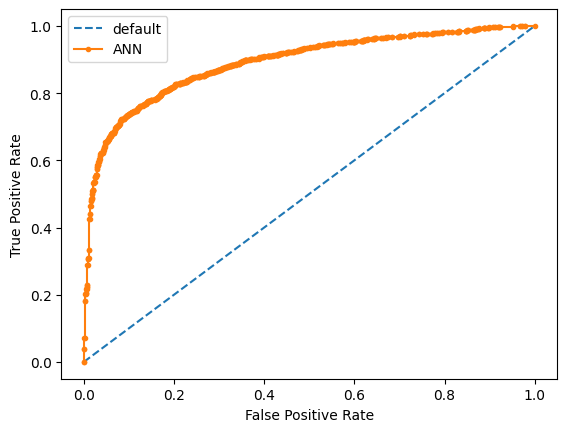

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ann_probs = y_probNN
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
ann_auc = roc_auc_score(y_test, ann_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('ANN: ROC AUC=%.3f' % (ann_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ann_fpr, ann_tpr, _ = roc_curve(y_test, ann_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='default')
plt.plot(ann_fpr, ann_tpr, marker='.', label='ANN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()